<a href="https://colab.research.google.com/github/grosetta/rdkit_study/blob/main/%E5%85%A8%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%EF%BC%88%E5%88%86%E7%B1%BB%E5%9E%8B%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#文件头代码
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/gdrive/My Drive/Colab Notebooks/python_package/")

Mounted at /content/gdrive


In [3]:
import os
os.chdir("/content/gdrive/MyDrive/data/")

In [36]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import IPythonConsole 

In [5]:
# 调试用
np.random.seed(123)

In [10]:
features = pd.read_excel("./features.xlsx")  
train_features = features.sample(frac=0.8, replace=False, random_state=0)
valid_features=features[~features.index.isin(train_features.index)]

target = pd.read_excel("./target.xlsx")
train_target = target.sample(frac=0.8, replace=False, random_state=0)
valid_target=target[~target.index.isin(train_target.index)]

weight = pd.read_excel("./weight.xlsx")
train_weight = weight.sample(frac=0.8, replace=False, random_state=0)
valid_weight=weight[~weight.index.isin(train_weight.index)]

In [11]:
tox21_tasks = ['SR-p53']
n_features = 1024

In [18]:
import tempfile
with tempfile.TemporaryDirectory() as data_dir:
    train_dataset = dc.data.DiskDataset.from_numpy(X=np.array(train_features, dtype='float32'), y=np.array(train_target, dtype='float32'), 
    w=np.array(train_weight, dtype='float32'), tasks = tox21_tasks, data_dir='./dev')
    print(train_dataset)

import tempfile
with tempfile.TemporaryDirectory() as data_dir:
    valid_dataset = dc.data.DiskDataset.from_numpy(X=np.array(valid_features, dtype='float32'), y=np.array(valid_target, dtype='float32'),
    w=np.array(valid_weight, dtype='float32'), tasks = tox21_tasks, data_dir='./val')
    print(valid_dataset)

<DiskDataset X.shape: (5011, 1024), y.shape: (5011, 1), w.shape: (5011, 1), task_names: ['SR-p53']>
<DiskDataset X.shape: (1253, 1024), y.shape: (1253, 1), w.shape: (1253, 1), task_names: ['SR-p53']>


In [19]:
# 搭建模型
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
model = dc.models.MultitaskClassifier(
    len(tox21_tasks),
    n_features,
    layer_sizes=[1000],
    dropouts=[.25],
    learning_rate=0.001,
    batch_size=50,
    use_queue=False)

In [20]:
# 训练模型
model.fit(train_dataset, nb_epoch=1)

0.3065994381904602

In [22]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric])
valid_scores = model.evaluate(valid_dataset, [metric])

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Evaluating model
Train scores
{'mean-roc_auc_score': 0.8761886992859833}
Validation scores
{'mean-roc_auc_score': 0.6846228385895146}


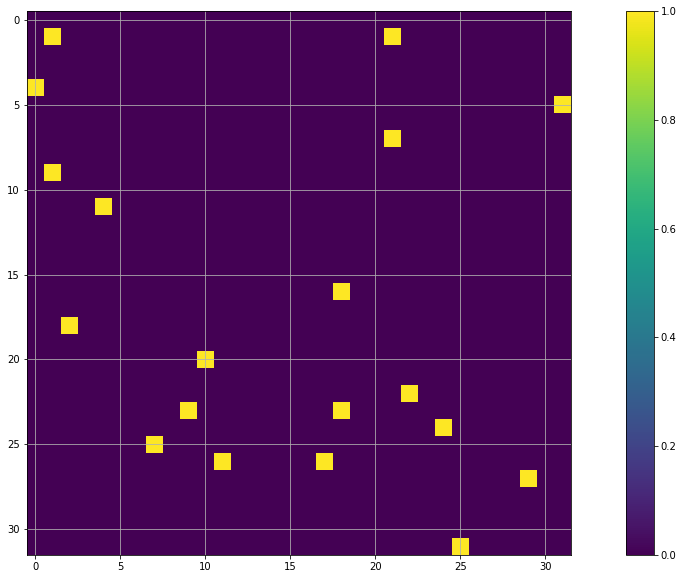

In [28]:
# 预知未知分子毒性
list_smiles = []
list_mols = Chem.SDMolSupplier('/content/gdrive/MyDrive/data/molecules.sdf')

for mol in list_mols:
    smi = Chem.MolToSmiles(mol)
    list_smiles.append(smi)


#ecfp指纹转化为图
smi = "CC(=O)Nc1ccc(O)cc1"
mol = Chem.MolFromSmiles(smi)
ECFP = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
binary = ECFP.ToBitString()
list1 = list(binary)
list2 = [int(i) for i in list1]
arr1 = np.array(list2).reshape(32,32)
fig = plt.subplots(figsize=(20, 10))
plt.imshow(arr1)
plt.colorbar()
plt.grid()

In [30]:
# smiles转换为mol分子
mols = [Chem.MolFromSmiles(i) for i in list_smiles]
mols = [Chem.AddHs(i) for i in mols]
test_features = pd.DataFrame()
for mol in mols:
    #fp = MACCSkeys.GenMACCSKeys(mol)
    ECFP = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    binary = ECFP.ToBitString()
    list1 = list(binary)
    df = pd.DataFrame(list1)
    test_features = pd.concat([test_features, df.T], axis=0)

In [31]:
try:
    os.mkdir('./test')
except FileExistsError:
    pass

In [34]:
import tempfile
with tempfile.TemporaryDirectory() as data_dir:
    test_dataset = dc.data.DiskDataset.from_numpy(X=np.array(test_features, dtype='float32'), tasks = tox21_tasks, data_dir='./test')
    print(test_dataset.X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [41]:
# 概率预测模型
dict_label = {0:'无毒性', 1:'有毒性'}
predictions_probability = model.predict(test_dataset)

for i, smi in enumerate(list_smiles):
    mol = Chem.MolFromSmiles(smi)
    Draw.MolToImage(mol, size=(600, 600))
    pred_label = dict_label[np.argmax(predictions_probability[i])]
    if pred_label=='无毒性':
        print('分子{}:\t'.format(i) + '这是一个AI预测' + pred_label + '的药物分子, 请放心做决策！')
    elif pred_label=='有毒性':
        print('分子{}:\t'.format(i) + '这是一个AI预测' + pred_label + '的药物分子, 请谨慎做决策！')
        Draw.MolToImage(mol, size=(600, 600))

分子0:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子1:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子2:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子3:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子4:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子5:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子6:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子7:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子8:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子9:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子10:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子11:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子12:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子13:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子14:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子15:	这是一个AI预测有毒性的药物分子, 请谨慎做决策！
分子16:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子17:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子18:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子19:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子20:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子21:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子22:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子23:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子24:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子25:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子26:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子27:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子28:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子29:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子30:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子31:	这是一个AI预测无毒性的